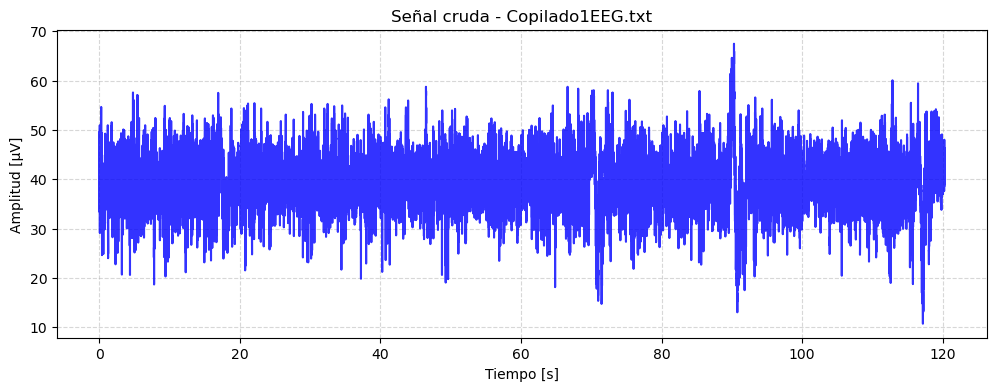

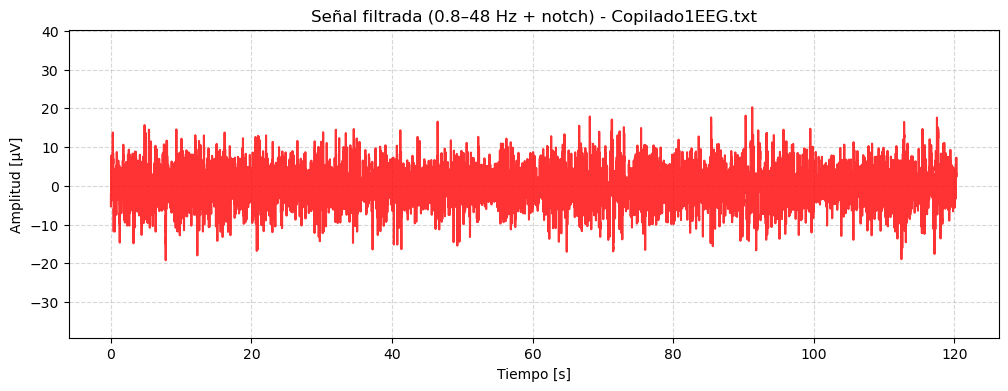

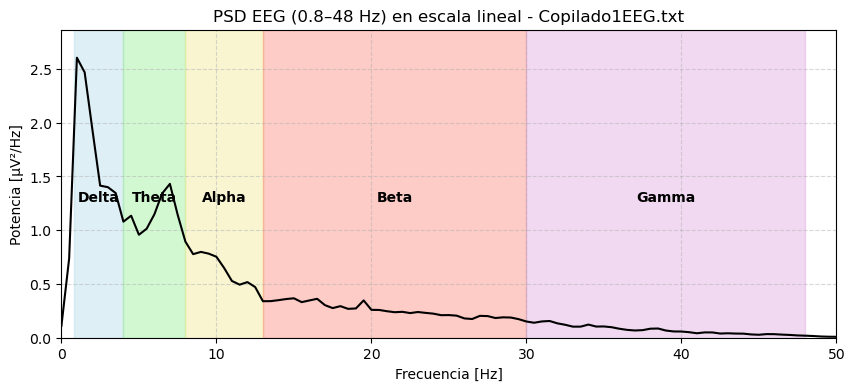

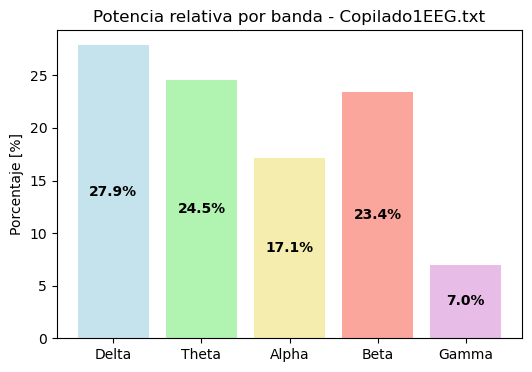

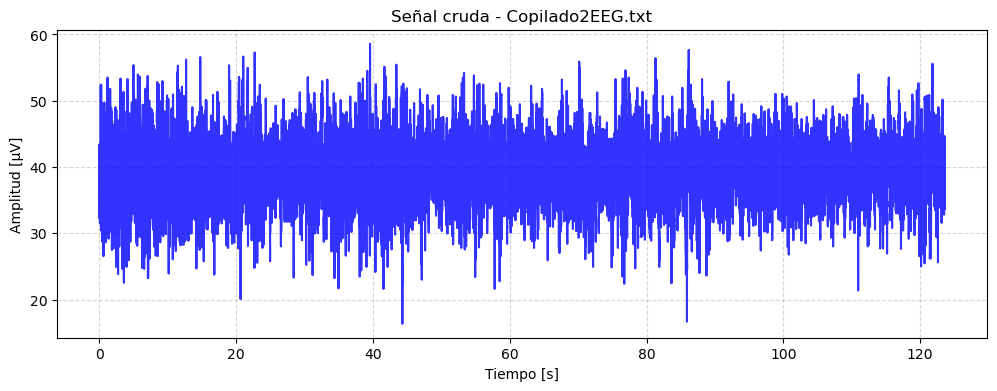

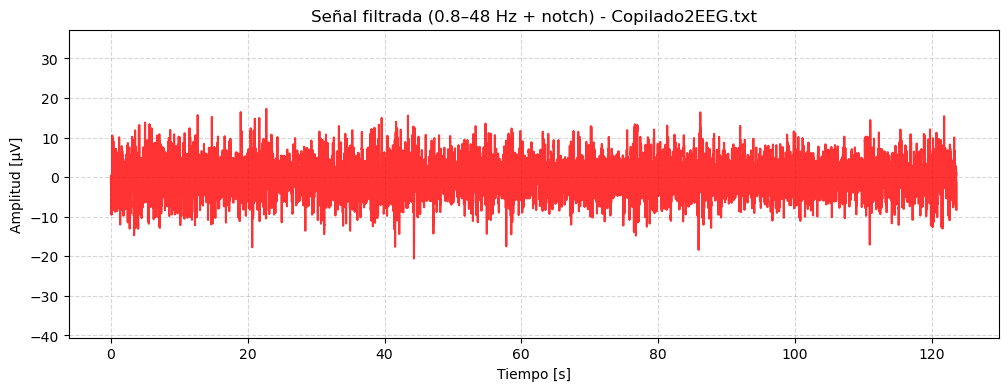

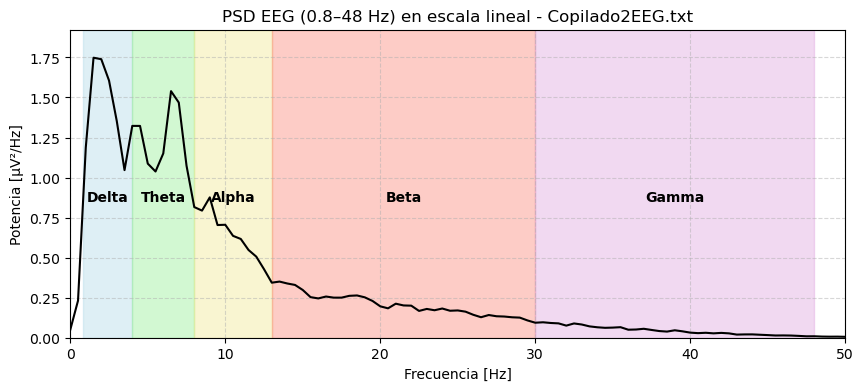

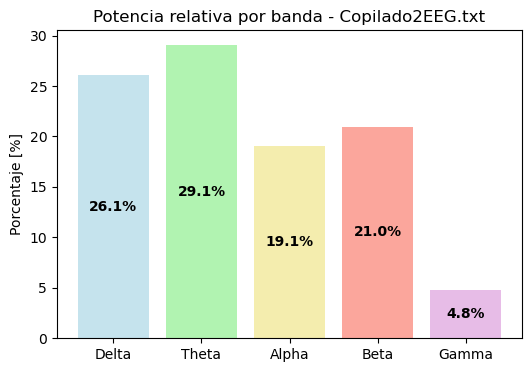

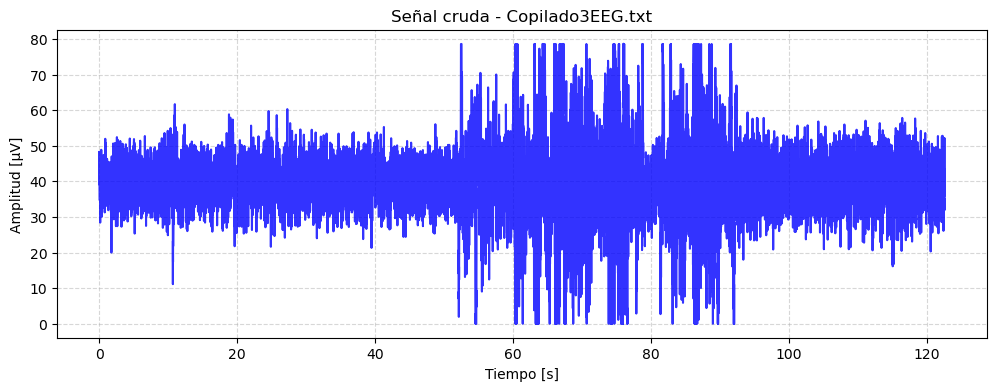

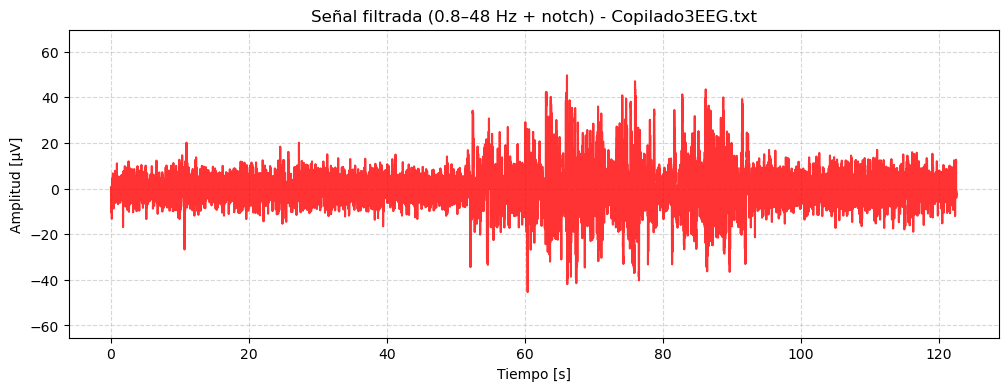

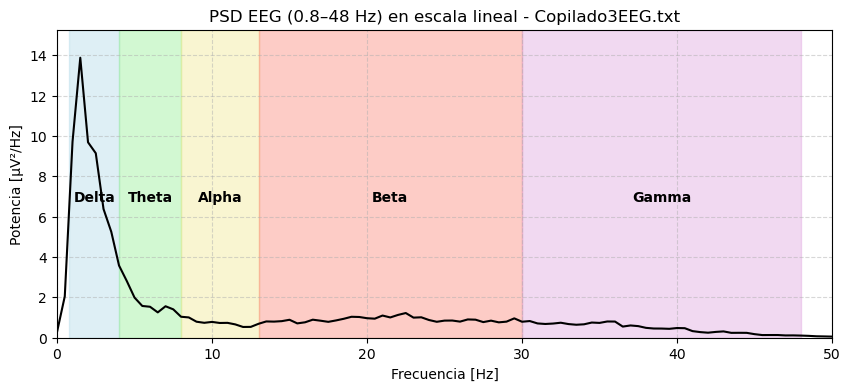

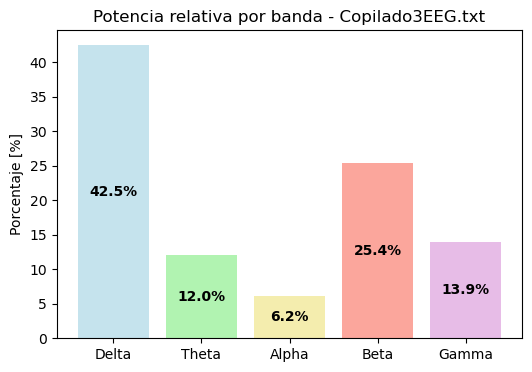

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch
import os

# === Archivos a procesar ===
archivos = [
    r"C:\SeñalesLab3\Lab4\Copilado1EEG.txt",
    r"C:\SeñalesLab3\Lab4\Copilado2EEG.txt",
    r"C:\SeñalesLab3\Lab4\Copilado3EEG.txt"
]

# === Parámetros BITalino ===
VCC = 3.3
Gain = 41782
ADCres = 1023
fs = 1000  # Hz

# === Funciones ===
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low, high = lowcut/nyq, highcut/nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, f0, fs, Q=30):
    b, a = iirnotch(f0/(0.5*fs), Q)
    return filtfilt(b, a, signal)

def bandpower_from_psd(freqs, psd, band):
    idx = np.logical_and(freqs >= band[0], freqs <= band[1])
    return np.trapezoid(psd[idx], freqs[idx])

# === Colores suaves por banda PSD ===
band_colors = {
    "Delta": ("lightblue", 0.8, 4),
    "Theta": ("lightgreen", 4, 8),
    "Alpha": ("khaki", 8, 13),
    "Beta":  ("salmon", 13, 30),
    "Gamma": ("plum", 30, 48)
}

bands = {name: (fmin, fmax) for name, (_, fmin, fmax) in band_colors.items()}

# === Procesar cada archivo ===
for archivo in archivos:
    df = pd.read_csv(archivo, sep="\t", comment="#",
                     names=["nSeq", "I1", "I2", "O1", "O2", "A4"])
    
    ADC = df["O2"].values
    Volt = (ADC / ADCres) * VCC
    EEG_uV = (Volt / Gain) * 1e6
    t = np.arange(len(EEG_uV)) / fs

    # --- Señal cruda ---
    plt.figure(figsize=(12,4))
    plt.plot(t, EEG_uV, color='blue', alpha=0.8)
    plt.title(f"Señal cruda - {os.path.basename(archivo)}")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [µV]")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # --- Filtrado pasabanda + notch ---
    EEG_bp = bandpass_filter(EEG_uV, 0.8, 48, fs)
    EEG_bp = notch_filter(EEG_bp, 60, fs, Q=30)
    EEG_bp = EEG_bp - np.mean(EEG_bp)

    # --- Señal filtrada ---
    plt.figure(figsize=(12,4))
    plt.plot(t, EEG_bp, color='red', alpha=0.8)
    plt.title(f"Señal filtrada (0.8–48 Hz + notch) - {os.path.basename(archivo)}")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [µV]")
    y_margin = 20
    plt.ylim([EEG_bp.min()-y_margin, EEG_bp.max()+y_margin])
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # --- PSD (escala lineal) ---
    nperseg = fs * 2
    freqs, psd = welch(EEG_bp, fs, nperseg=nperseg)

    plt.figure(figsize=(10,4))
    plt.plot(freqs, psd, color='black', label='PSD')

    # Colorear bandas y agregar etiquetas internas
    for name, (color, fmin, fmax) in band_colors.items():
        plt.axvspan(fmin, fmax, color=color, alpha=0.4)
        plt.text((fmin+fmax)/2, max(psd)*0.5, name,
                 ha='center', va='center', fontsize=10, fontweight='bold')

    plt.title(f"PSD EEG (0.8–48 Hz) en escala lineal - {os.path.basename(archivo)}")
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("Potencia [µV²/Hz]")
    plt.xlim([0, 50])
    plt.ylim([0, max(psd)*1.1])  # margen del 10% sobre el máximo
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # --- Potencia relativa por bandas ---
    band_powers = {name: bandpower_from_psd(freqs, psd, band) for name, band in bands.items()}
    p_total = bandpower_from_psd(freqs, psd, (0.8, 48))
    rel_power = {k: (v / p_total * 100) for k, v in band_powers.items()}

    plt.figure(figsize=(6,4))
    bars = plt.bar(rel_power.keys(), rel_power.values(),
                   color=[band_colors[k][0] for k in rel_power.keys()],
                   alpha=0.7)

    # Etiquetas internas de porcentaje
    for bar, val in zip(bars, rel_power.values()):
        plt.text(bar.get_x() + bar.get_width()/2, val/2,
                 f"{val:.1f}%", ha='center', va='center', fontsize=10, fontweight='bold')

    plt.title(f"Potencia relativa por banda - {os.path.basename(archivo)}")
    plt.ylabel("Porcentaje [%]")
    plt.show()



Potencias Alpha (µV²):
            Archivo  Cerrados  Abiertos
0  Copilado1EEG.txt  3.219497  3.248017
1  Copilado2EEG.txt  3.182308  3.062054
2  Copilado3EEG.txt  2.519260  4.883532

Comparación estadística (Cerrados vs Abiertos):
T-test pareado: t=-0.942, p=0.4458
Wilcoxon: stat=2.000, p=0.7500


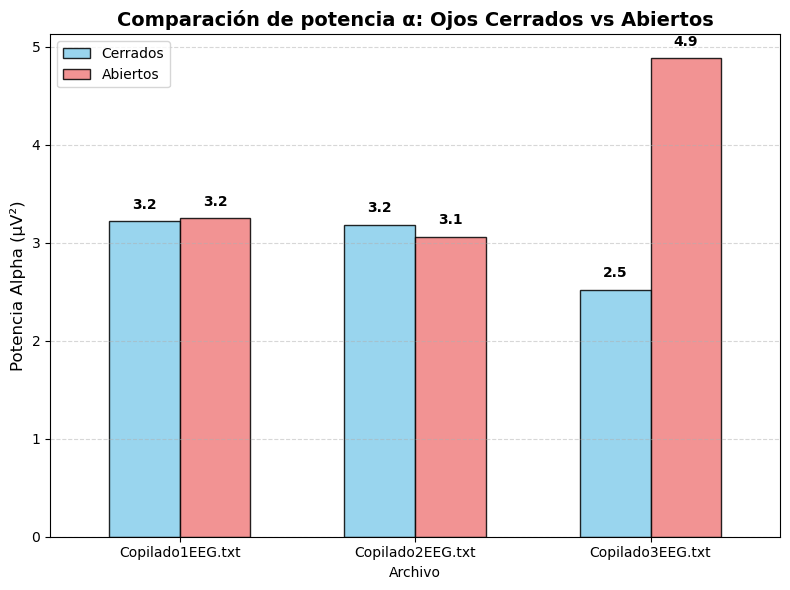

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from scipy.stats import ttest_rel, wilcoxon
import os

# === Funciones ===
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, signal)

def potencia_alpha(signal, fs, low=8, high=13, nperseg=2*1000):
    f, Pxx = welch(signal, fs=fs, nperseg=nperseg)
    idx = np.logical_and(f >= low, f <= high)
    return np.trapezoid(Pxx[idx], f[idx])

# === Archivos ===
archivos = [
    r"C:\SeñalesLab3\Lab4\Copilado1EEG.txt",
    r"C:\SeñalesLab3\Lab4\Copilado2EEG.txt",
    r"C:\SeñalesLab3\Lab4\Copilado3EEG.txt"
]

VCC = 3.3
Gain = 41782
ADCres = 1023
fs = 1000  # Hz

resultados = []

for archivo in archivos:
    df = pd.read_csv(archivo, sep="\t", comment="#",
                     names=["nSeq", "I1", "I2", "O1", "O2", "A4"])
    
    ADC = df["O2"].values
    Volt = (ADC / ADCres) * VCC
    EEG_uV = (Volt / Gain) * 1e6
    EEG_filt = bandpass_filter(EEG_uV, 0.8, 48, fs)

    n_total = len(EEG_filt)
    nC = int(30*fs)
    nA = int(120*fs)

    if n_total >= (nC + nA + nC):
        seg_c1 = EEG_filt[:nC]
        seg_ab = EEG_filt[nC:nC+nA]
        seg_c2 = EEG_filt[nC+nA:nC+nA+nC]
    else:
        nC = n_total // 4
        nA = n_total // 2
        seg_c1 = EEG_filt[:nC]
        seg_ab = EEG_filt[nC:nC+nA]
        seg_c2 = EEG_filt[nC+nA:]

    pC_mean = (potencia_alpha(seg_c1, fs) + potencia_alpha(seg_c2, fs)) / 2
    pA_mean = potencia_alpha(seg_ab, fs)

    resultados.append({
        "Archivo": os.path.basename(archivo),
        "Cerrados": pC_mean,
        "Abiertos": pA_mean
    })

df_res = pd.DataFrame(resultados)
print("\nPotencias Alpha (µV²):")
print(df_res)

# === Estadística ===
cerrados = df_res["Cerrados"]
abiertos = df_res["Abiertos"]

tstat, p_t = ttest_rel(cerrados, abiertos)
wstat, p_w = wilcoxon(cerrados, abiertos)

print("\nComparación estadística (Cerrados vs Abiertos):")
print(f"T-test pareado: t={tstat:.3f}, p={p_t:.4f}")
print(f"Wilcoxon: stat={wstat:.3f}, p={p_w:.4f}")

# === Gráfico mejorado ===
df_plot = df_res.set_index("Archivo")[["Cerrados", "Abiertos"]]

ax = df_plot.plot(kind="bar", figsize=(8,6),
                  color=["skyblue", "lightcoral"], width=0.6, alpha=0.85, edgecolor='black')

plt.ylabel("Potencia Alpha (µV²)", fontsize=12)
plt.title("Comparación de potencia α: Ojos Cerrados vs Abiertos", fontsize=14, fontweight='bold')
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Valores encima de cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',
                (p.get_x() + p.get_width()/2, p.get_height() + max(df_plot.max())*0.02),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Eje X horizontal
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



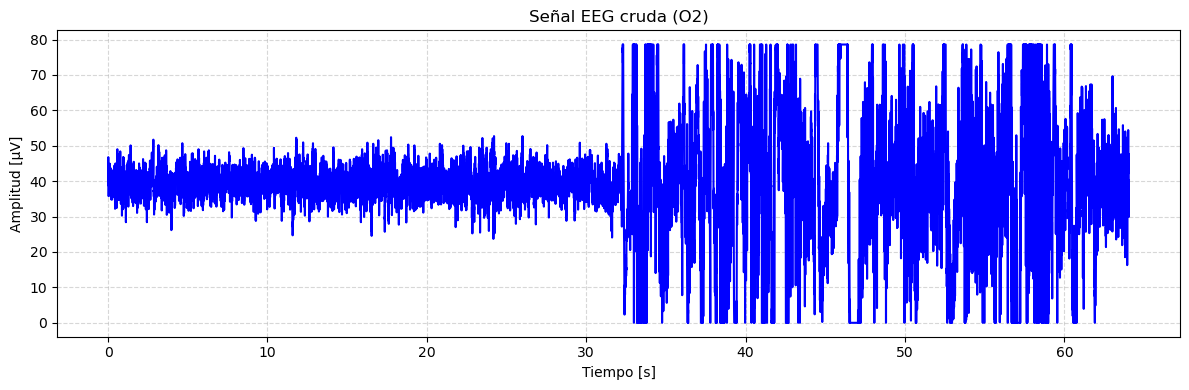

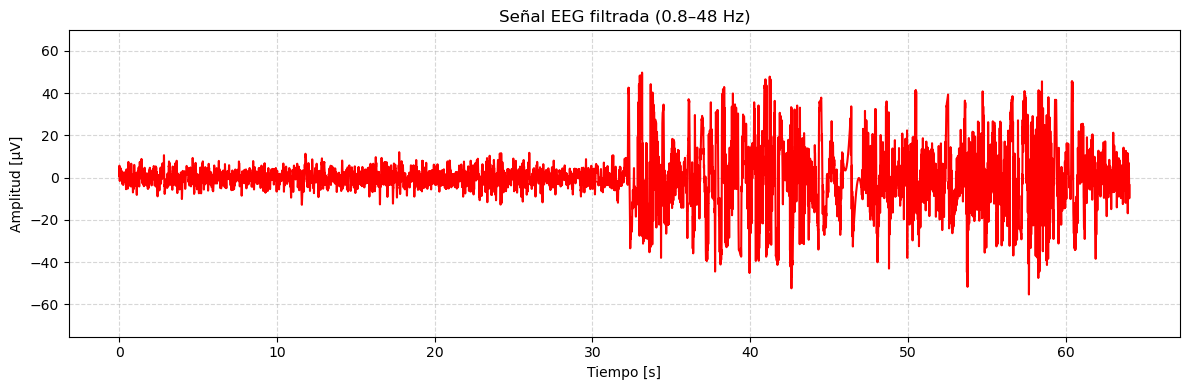

Potencias Beta (µV²) - media ± DE
Reposo: 2.262 ± 0.501
Tarea : 27.659 ± 31.810

T-test pareado: t = -1.302, p = 0.2406


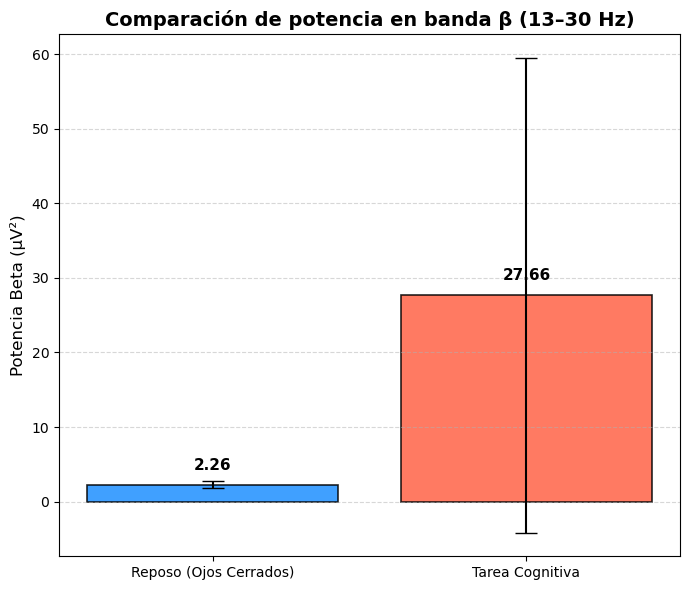

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from scipy.stats import ttest_rel

# === Funciones auxiliares ===
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, signal)

def bandpower(signal, fs, band, nperseg=2000):
    freqs, psd = welch(signal, fs, nperseg=nperseg)
    idx = np.logical_and(freqs >= band[0], freqs <= band[1])
    return np.trapezoid(psd[idx], freqs[idx])  # cambio de trapz a trapezoid

# === Parámetros BITalino ===
VCC = 3.3
Gain = 41782
ADCres = 1023
fs = 1000  # Hz

# === Leer archivo ===
ruta = r"C:\SeñalesLab3\Lab4\RestaEEG.txt"
df = pd.read_csv(ruta, sep="\t", comment="#",
                 names=["nSeq", "I1", "I2", "O1", "O2", "A4"])

# Canal O2
ADC = df["O2"].values
Volt = (ADC / ADCres) * VCC
EEG_uV = (Volt / Gain) * 1e6
t = np.arange(len(EEG_uV)) / fs

# === Señal cruda ===
plt.figure(figsize=(12,4))
plt.plot(t, EEG_uV, color='blue')
plt.title("Señal EEG cruda (O2)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud [µV]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === Filtrado 0.8–48 Hz ===
EEG_filt = bandpass_filter(EEG_uV, 0.8, 48, fs)

# === Señal filtrada ===
plt.figure(figsize=(12,4))
plt.plot(t, EEG_filt, color='red')
plt.title("Señal EEG filtrada (0.8–48 Hz)")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud [µV]")
y_margin = 20
plt.ylim([EEG_filt.min()-y_margin, EEG_filt.max()+y_margin])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === Definir condiciones ===
reposo = EEG_filt[0:int(15*fs)]
tarea  = EEG_filt[int(15*fs):]

# === Potencia β (13–30 Hz) por ventanas de 2 s ===
ventana = 2 * fs
def obtener_potencias(segmento, fs, band=(13,30)):
    potencias = []
    for i in range(0, len(segmento)-ventana+1, ventana):
        sub = segmento[i:i+ventana]
        pot = bandpower(sub, fs, band, nperseg=ventana)
        potencias.append(pot)
    return np.array(potencias)

pot_reposo = obtener_potencias(reposo, fs)
pot_tarea  = obtener_potencias(tarea, fs)

# === Estadística ===
n = min(len(pot_reposo), len(pot_tarea))
tstat, pval = ttest_rel(pot_reposo[:n], pot_tarea[:n])

print("Potencias Beta (µV²) - media ± DE")
print(f"Reposo: {np.mean(pot_reposo):.3f} ± {np.std(pot_reposo):.3f}")
print(f"Tarea : {np.mean(pot_tarea):.3f} ± {np.std(pot_tarea):.3f}")
print(f"\nT-test pareado: t = {tstat:.3f}, p = {pval:.4f}")

# === Gráfico comparativo mejorado ===
labels = ["Reposo (Ojos Cerrados)", "Tarea Cognitiva"]
means = [np.mean(pot_reposo), np.mean(pot_tarea)]
errs  = [np.std(pot_reposo), np.std(pot_tarea)]

plt.figure(figsize=(7,6))
bars = plt.bar(labels, means, yerr=errs, capsize=8, alpha=0.85,
               color=["dodgerblue", "tomato"], edgecolor='black', linewidth=1.2)

# Valores encima de cada barra
for bar, val in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(errs)*0.05,
             f"{val:.2f}", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.ylabel("Potencia Beta (µV²)", fontsize=12)
plt.title("Comparación de potencia en banda β (13–30 Hz)", fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


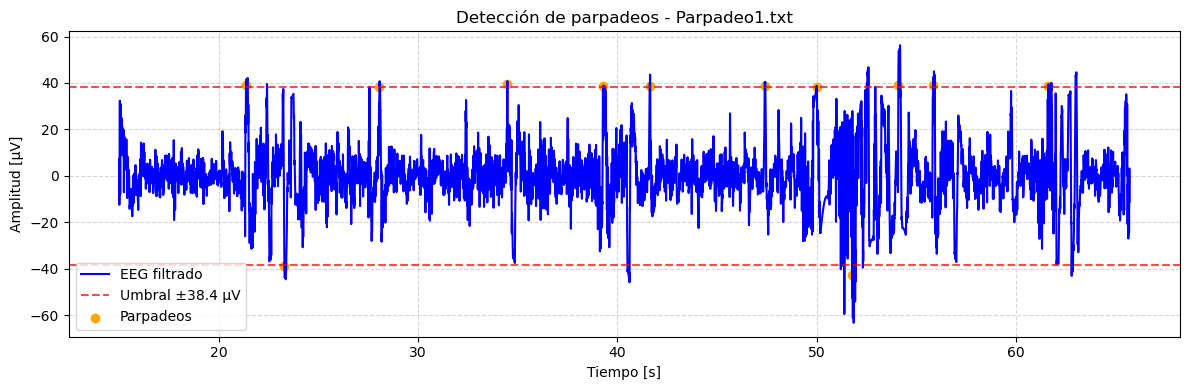

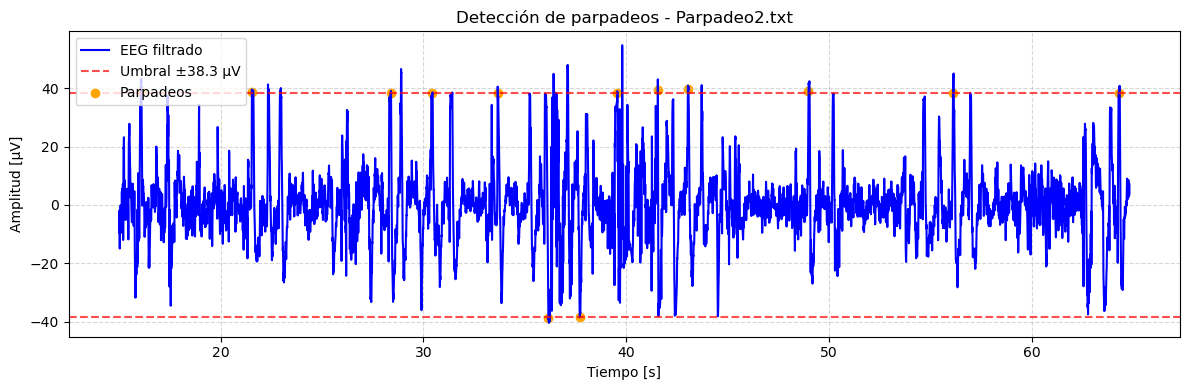

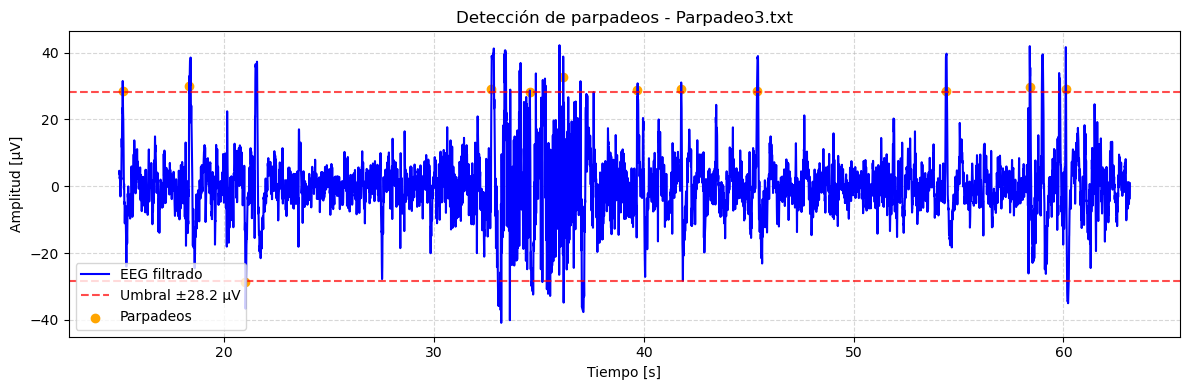


Número de parpadeos detectados (umbral adaptativo, ventana 15–60 s):
         Archivo  Parpadeos  Umbral_µV
0  Parpadeo1.txt         12  38.415441
1  Parpadeo2.txt         13  38.288961
2  Parpadeo3.txt         12  28.224511


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import os

# === Función de filtrado pasa-banda ===
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# === Detección de parpadeos adaptativa ===
def detectar_parpadeos(signal, fs, factor=3, min_dist=1.5):
    """
    signal: EEG filtrado en µV
    fs: frecuencia de muestreo
    factor: múltiplo de desviación estándar para el umbral
    min_dist: separación mínima entre parpadeos [s]
    """
    umbral = factor * np.std(signal)
    indices = np.where(np.abs(signal) > umbral)[0]
    if len(indices) == 0:
        return [], umbral
    
    # Agrupar muestras cercanas como un solo evento
    eventos = [indices[0]]
    for i in indices[1:]:
        if (i - eventos[-1]) > (min_dist * fs):
            eventos.append(i)
    
    return eventos, umbral

# === Archivos de parpadeo ===
archivos = [
    r"C:\SeñalesLab3\Lab4\Parpadeo1.txt",
    r"C:\SeñalesLab3\Lab4\Parpadeo2.txt",
    r"C:\SeñalesLab3\Lab4\Parpadeo3.txt"
]

# === Parámetros BITalino ===
VCC = 3.3
Gain = 41782
ADCres = 1023
fs = 1000  # Hz

# === Guardar resultados ===
resultados = []

for archivo in archivos:
    df = pd.read_csv(archivo, sep="\t", comment="#",
                     names=["nSeq", "I1", "I2", "O1", "O2", "A4"])
    
    # Canal frontal O2
    ADC = df["O2"].values
    Volt = (ADC / ADCres) * VCC
    EEG_uV = (Volt / Gain) * 1e6
    
    # Filtrado 0.8–48 Hz
    EEG_filt = bandpass_filter(EEG_uV, 0.8, 48, fs)
    
    # --- Ventana específica de parpadeos ---
    inicio = int(15*fs)          # 15 s
    fin    = len(EEG_filt)       # hasta el final
    EEG_segmento = EEG_filt[inicio:fin]
    t_segmento = np.arange(inicio, fin) / fs

    # Detectar parpadeos
    eventos, umbral = detectar_parpadeos(EEG_segmento, fs, factor=3, min_dist=1.5)
    n_parpadeos = len(eventos)
    
    resultados.append({
        "Archivo": os.path.basename(archivo),
        "Parpadeos": n_parpadeos,
        "Umbral_µV": umbral
    })
    
    # --- Graficar ---
    plt.figure(figsize=(12,4))
    plt.plot(t_segmento, EEG_segmento, label="EEG filtrado", color="blue")
    plt.axhline(umbral, color="red", linestyle="--", alpha=0.7, label=f"Umbral ±{umbral:.1f} µV")
    plt.axhline(-umbral, color="red", linestyle="--", alpha=0.7)
    if len(eventos) > 0:
        plt.scatter(t_segmento[eventos], EEG_segmento[eventos], color="orange", label="Parpadeos")
    plt.title(f"Detección de parpadeos - {os.path.basename(archivo)}")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [µV]")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# === Resultados finales ===
df_res = pd.DataFrame(resultados)
print("\nNúmero de parpadeos detectados (umbral adaptativo, ventana 15–60 s):")
print(df_res)
